In [12]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
import pickle
from pathlib import Path
from typing import List, Dict, Optional
from datetime import timedelta
from collections.abc import Mapping
from scipy.ndimage import uniform_filter1d


def fmt_seconds(seconds: float) -> str:
    if seconds is None or np.isnan(seconds):
        return "–"
    td = timedelta(seconds=int(seconds))
    h, remainder = divmod(td.seconds, 3600)
    m, s = divmod(remainder, 60)
    h += td.days * 24
    return f"{h}h {m}m {s}s"


class PerformanceDashboard:
    """
    Visualize inference performance metrics comparing supervoxel types.
    - Separate computation and visualization
    - Store computed metrics for reuse
    - Create separate plot and table figures
    """

    def __init__(
        self,
        entity: str = "giuliosichili",
        project: str = "automi",
        group_key: str = "group",
        supervoxel_key: str = "supervoxel_type",
        excluded_groups: List[str] = ["ABPC"],
        page_size: int = 256,
        smoothing_window: int = 5,
        alias_map: Optional[Dict[str, str]] = None,
        band_type: str = "quantile",  # "std" or "quantile"
        band_quantile: float = 0.25,   # q for quantile bands -> [q, 1-q]
        debug: bool = False,
    ):
        self.entity = entity
        self.project = project
        self.page_size = page_size
        self.group_key = group_key
        self.supervoxel_key = supervoxel_key
        self.excluded_groups = excluded_groups
        self.smoothing_window = smoothing_window
        self.debug = debug
        # Human-friendly labels for visualizations
        self.alias_map = alias_map or {
            "full-organs": "Full organs",
            "FCC": "Regular",
            "FCC-organs": "Hybrid",
        }
        self.band_type = band_type
        self.band_quantile = band_quantile
        self._api = wandb.Api()

    def compute_metrics(self, supervoxel_types: List[str] = ["full-organs", "FCC", "FCC-organs"]):
        """Compute and save metrics for all supervoxel types."""
        # Create metrics directory if it doesn't exist
        metrics_dir = Path("performance_metrics")
        metrics_dir.mkdir(exist_ok=True)

        print("Computing performance metrics for all supervoxel types...")
        for sv_type in supervoxel_types:
            runs = self._fetch_runs(sv_type)
            if not runs:
                print(f"[warning] No runs found for supervoxel_type='{sv_type}'")
                continue
            print(f"[info] Found {len(runs)} runs for supervoxel_type='{sv_type}'")

            data = self._collect_metrics(runs)

            # Save to file
            filename = metrics_dir / f"performance_metrics_{sv_type}.pkl"
            with open(filename, 'wb') as f:
                pickle.dump(data, f)

            print(f"Computed and saved metrics for {sv_type}")

    def load_metrics(self, supervoxel_type: str):
        """Load precomputed metrics from file."""
        metrics_dir = Path("performance_metrics")
        filename = metrics_dir / f"performance_metrics_{supervoxel_type}.pkl"

        try:
            with open(filename, 'rb') as f:
                return pickle.load(f)
        except FileNotFoundError:
            print(f"Metrics file not found: {filename}")
            print("Run compute_metrics() first.")
            return None

    def plot_comparison(
        self,
        supervoxel_types: List[str] = ["full-organs", "FCC", "FCC-organs"],
        save: bool = False,
        dpi: int = 300,
        smoothing_window: Optional[int] = None,
        band: Optional[str] = None,            # "std" or "quantile"
        quantile: Optional[float] = None,      # if band == "quantile": use [q, 1-q]
    ):
        """Create comparison plots using precomputed metrics.
        - smoothing_window: overrides the instance default when provided.
        - band: choose band type: "std" or "quantile" (default: "quantile").
        - quantile: q in (0, 0.5], uses [q, 1-q] (default: 0.25 -> IQR).
        Center: mean for std band, median for quantile band (default).
        """
        if smoothing_window is not None:
            window = smoothing_window
        else:
            window = self.smoothing_window

        band_type = (band or self.band_type).lower()
        q = self.band_quantile if quantile is None else float(quantile)
        # validate q
        if band_type == "quantile":
            if not (0.0 < q <= 0.5):
                print(f"[warning] invalid quantile {q}, using 0.25")
                q = 0.25

        # Load all metrics
        all_data = {}
        for sv_type in supervoxel_types:
            data = self.load_metrics(sv_type)
            if data is None:
                return
            all_data[sv_type] = data

        if not all_data:
            print("[error] No data found for any supervoxel type")
            return

        # Create plots figure
        fig_plots = self._create_plots_figure(all_data, window, band_type, q)
        if save:
            fname_plots = "performance_dashboard_plots.png"
            fig_plots.savefig(fname_plots, dpi=dpi, bbox_inches="tight")
            print(f"[saved] {fname_plots}")

        # Create table figure
        fig_table = self._create_table_figure(all_data)
        if save:
            fname_table = "performance_dashboard_table.png"
            fig_table.savefig(fname_table, dpi=dpi, bbox_inches="tight")
            print(f"[saved] {fname_table}")

        plt.show()

    def _fetch_runs(self, supervoxel_type: str) -> List[wandb.apis.public.Run]:
        path = f"{self.entity}/{self.project}"
        filters = {
            f"config.{self.supervoxel_key}": {"$eq": supervoxel_type},
            "$or": [
                {
                    f"config.{self.group_key}": {"$eq": "fixed-aggregation"},
                    "config.supervoxel_type": {"$ne": "FCC-organs"}
                },
                {
                    f"config.{self.group_key}": {"$exists": False},
                    "config.aggregation_function": {"$eq": "true_positive_aggregation"},
                    "config.supervoxel_type": {"$ne": "FCC-organs"}
                },
                {
                    f"config.{self.group_key}": {"$eq": "performance-check"},
                    "config.supervoxel_type": {"$eq": "FCC-organs"}
                }
            ]
        }
        return list(self._api.runs(path, filters=filters))

    def _collect_metrics(self, runs: List[wandb.apis.public.Run]) -> Dict:
        curves = {"inference_time_sec": [], "cache_hit_ratio_percent": []}
        scalars = {"runtime_sec": [], "n_samples": []}

        for r in runs:
            per_run_series = {k: {} for k in curves}

            try:
                history = r.history(keys=list(curves), pandas=False)
                for row in history:
                    step = row.get("_step", row.get("step"))
                    if step is None:
                        continue
                    for key in curves:
                        val = row.get(key, None)
                        if val is not None:
                            per_run_series[key][int(step)] = float(val)
            except Exception as e:
                print(f"[warning] Failed to read history from run {r.id}: {e}")

            for key in curves:
                if len(per_run_series[key]) == 0:
                    print(f"[warning] No usable history for {key} in run {r.id}")
                    continue
                steps_sorted = np.array(sorted(per_run_series[key].keys()), dtype=int)
                values_sorted = np.array([per_run_series[key][s] for s in steps_sorted], dtype=float)
                curves[key].append({"steps": steps_sorted, "values": values_sorted})

            # scalari dal summary
            try:
                total_sec = float(r.summary.get("_runtime", np.nan))
                if not np.isnan(total_sec):
                    scalars["runtime_sec"].append(total_sec)
            except Exception:
                pass

            # n_samples: ora dalla config (con fallback)
            n_samples = self._get_n_samples(r)
            if not np.isnan(n_samples):
                scalars["n_samples"].append(n_samples)

        return {"curves": curves, "scalars": scalars}

    def _smooth_curve(self, y: np.ndarray, window_size: int) -> np.ndarray:
        """Apply smoothing to a curve using a nan-aware moving average (uniform filter).
        - Clips window_size to length of y.
        - Ensures odd window for symmetry.
        - Interpolates internal NaNs before smoothing (keeps leading/trailing NaNs if all NaN).
        """
        if window_size is None or window_size <= 1:
            return y
        n = len(y)
        if n < 3:
            return y
        window_size = min(int(window_size), n)
        if window_size % 2 == 0 and window_size > 1:
            window_size -= 1  # make it odd for symmetry
        y = y.astype(float)
        isnan = np.isnan(y)
        if isnan.all():
            return y
        if isnan.any():
            # simple linear interpolation for interior NaNs
            idx = np.arange(n)
            good = ~isnan
            y_interp = y.copy()
            y_interp[isnan] = np.interp(idx[isnan], idx[good], y[good])
        else:
            y_interp = y
        sm = uniform_filter1d(y_interp, size=window_size, mode='nearest')
        if self.debug:
            print(f"[smooth] window={window_size} pre_std={np.nanstd(y):.3f} post_std={np.nanstd(sm):.3f}")
        return sm

    def _aggregate_over_steps(
        self,
        series_list,
        window_size: Optional[int] = None,
        band_type: str = "quantile",
        q: float = 0.25,
    ):
        """Aggregate series over common steps and compute band.
        Returns: steps, center, lower_band, upper_band
        - center is mean across runs for std band, median across runs for quantile band
        - band is either ± std or [q, 1-q] quantile across runs
        """
        all_steps = sorted(set(int(s) for d in series_list for s in d["steps"]))
        if len(all_steps) == 0:
            return np.array([]), np.array([]), np.array([]), np.array([])
        step_to_idx = {s: i for i, s in enumerate(all_steps)}

        M = np.full((len(series_list), len(all_steps)), np.nan, dtype=float)
        for i, d in enumerate(series_list):
            for s, v in zip(d["steps"], d["values"]):
                j = step_to_idx[int(s)]
                M[i, j] = v

        band_type = band_type.lower()
        if band_type == "std":
            mu = np.nanmean(M, axis=0)
            with np.errstate(invalid="ignore"):
                sd = np.nanstd(M, axis=0, ddof=1)
            sd = np.where(np.isnan(sd), 0.0, sd)
            lower = mu - sd
            upper = mu + sd
        else:
            # quantile band [q, 1-q] with median center
            mu = np.nanmedian(M, axis=0)
            q_low = np.nanpercentile(M, q * 100.0, axis=0)
            q_high = np.nanpercentile(M, (1.0 - q) * 100.0, axis=0)
            lower, upper = q_low, q_high

        # Apply smoothing
        w = window_size if window_size is not None else self.smoothing_window
        mu = self._smooth_curve(mu, w)
        lower = self._smooth_curve(lower, w)
        upper = self._smooth_curve(upper, w)

        return np.array(all_steps, dtype=int), mu, lower, upper

    def _create_plots_figure(self, all_data: Dict, window_size: int, band_type: str, q: float) -> plt.Figure:
        """Create comparison plots figure."""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        colors = ['tab:blue', 'tab:red', 'tab:green']
        supervoxel_types = list(all_data.keys())

        metric_info = [
            ("inference_time_sec", "Inference Time (s)", 0),
            ("cache_hit_ratio_percent", "Cache Hit Ratio (%)", 1)
        ]

        for metric_key, ylabel, ax_idx in metric_info:
            ax = axes[ax_idx]

            for i, (sv_type, color) in enumerate(zip(supervoxel_types, colors[:len(supervoxel_types)])):
                data = all_data[sv_type]
                series_list = data["curves"][metric_key]

                if len(series_list) == 0:
                    continue

                x, mu, lo, hi = self._aggregate_over_steps(series_list, window_size, band_type, q)

                # Human-readable label
                label = self.alias_map.get(sv_type, sv_type)
                # Plot with subtle styling
                ax.plot(x, mu, lw=1.5, label=label, color=color, alpha=0.85)
                ax.fill_between(x, lo, hi, alpha=0.20, color=color, linewidth=0)

            center_txt = ("mean" if band_type == "std" else "median")
            band_txt = ("±1 SD" if band_type == "std" else f"{int(q*100)}–{int((1-q)*100)} pct")
            ax.set_title(f'{ylabel} (smooth w={window_size}, center: {center_txt}, band: {band_txt})')
            ax.set_xlabel("Step")
            ax.set_ylabel(ylabel)
            ax.grid(True, alpha=0.3, linestyle=':')
            ax.legend()

        fig.suptitle("Performance Metrics Comparison by Supervoxel Type", fontsize=14, y=0.98)
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        return fig

    def _create_table_figure(self, all_data: Dict) -> plt.Figure:
        """Create table figure."""
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.axis('off')

        supervoxel_types = list(all_data.keys())

        # Prepare table data
        table_data = []
        for sv_type in supervoxel_types:
            data = all_data[sv_type]
            scalars = data["scalars"]
            curves = data["curves"]

            # Runtime and samples
            rt = np.array(scalars["runtime_sec"])
            ns = np.array(scalars["n_samples"])
            rt_mu = np.nanmean(rt) if rt.size else np.nan
            rt_sd = np.nanstd(rt, ddof=1) if rt.size > 1 else (0.0 if rt.size == 1 else np.nan)
            ns_mu = np.nanmean(ns) if ns.size else np.nan
            ns_sd = np.nanstd(ns, ddof=1) if ns.size > 1 else (0.0 if ns.size == 1 else np.nan)

            # Compute scalar global averages across runs for time and hits
            def _aggregate_scalar(series_list):
                vals = []
                for d in series_list:
                    v = np.nanmean(np.array(d.get("values", []), dtype=float)) if len(d.get("values", [])) > 0 else np.nan
                    vals.append(v)
                arr = np.array(vals, dtype=float)
                mu = np.nanmean(arr) if arr.size else np.nan
                sd = np.nanstd(arr, ddof=1) if arr.size > 1 else (0.0 if arr.size == 1 else np.nan)
                return mu, sd

            it_mu, it_sd = _aggregate_scalar(curves["inference_time_sec"])
            ch_mu, ch_sd = _aggregate_scalar(curves["cache_hit_ratio_percent"])

            human_label = self.alias_map.get(sv_type, sv_type)
            row_data = [
                human_label,
                fmt_seconds(rt_mu) + (f" ± {fmt_seconds(rt_sd)}" if not np.isnan(rt_sd) else ""),
                (f"{ns_mu:.1f}" if not np.isnan(ns_mu) else "–") + (f" ± {ns_sd:.1f}" if not np.isnan(ns_sd) else ""),
                (f"{it_mu:.2f} s" if not np.isnan(it_mu) else "–") + (f" ± {it_sd:.2f} s" if not np.isnan(it_sd) else ""),
                (f"{ch_mu:.1f} %" if not np.isnan(ch_mu) else "–") + (f" ± {ch_sd:.1f} %" if not np.isnan(ch_sd) else ""),
            ]
            table_data.append(row_data)

        # Create table
        col_labels = ["Supervoxel Type", "Runtime", "#Samples", "Avg Inference Time", "Avg Cache Hit Ratio"]

        table = ax.table(
            cellText=table_data,
            colLabels=col_labels,
            cellLoc="center",
            loc="center",
            colWidths=[0.25, 0.2, 0.15, 0.2, 0.2]
        )

        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 2.0)

        # Style the table
        for (i, j), cell in table.get_celld().items():
            if i == 0:  # Header
                cell.set_text_props(weight='bold')
                cell.set_facecolor('#E6E6FA')
            else:
                cell.set_facecolor('#F8F8FF')

        fig.suptitle("Performance Metrics Summary by Supervoxel Type", fontsize=14, y=0.85)
        return fig

    def _get_n_samples(self, r: wandb.apis.public.Run) -> float:
        """
        Cerca n_samples in ordine: config (anche annidata) -> summary -> history.
        Ritorna np.nan se non trovato.
        """
        candidate_keys = ["n_samples", "num_samples", "n_total", "dataset_size"]

        def deep_find(d: Mapping) -> Optional[float]:
            for k, v in d.items():
                if k in candidate_keys and isinstance(v, (int, float)):
                    return float(v)
                if isinstance(v, Mapping):
                    found = deep_find(v)
                    if found is not None:
                        return found
                elif isinstance(v, list):
                    for it in v:
                        if isinstance(it, Mapping):
                            found = deep_find(it)
                            if found is not None:
                                return found
            return None

        # 1) CONFIG
        try:
            conf = dict(r.config)  # DotDict -> dict
            val = deep_find(conf)
            if val is not None:
                return val
        except Exception:
            pass

        # 2) SUMMARY (fallback)
        for k in candidate_keys:
            try:
                v = r.summary.get(k, None)
                if v is not None:
                    return float(v)
            except Exception:
                continue

        # 3) HISTORY (fallback: prima occorrenza)
        try:
            for row in r.history(keys=candidate_keys, pandas=False):
                for k in candidate_keys:
                    v = row.get(k, None)
                    if v is not None:
                        return float(v)
        except Exception:
            pass

        return np.nan

In [13]:
dash = PerformanceDashboard(excluded_groups=["ABPC-volumes", "inference_stats"], smoothing_window=20)

In [14]:
# Compute metrics for all supervoxel types (run once)
#dash.compute_metrics(supervoxel_types=["full-organs", "FCC", "FCC-organs"])

[saved] performance_dashboard_plots.png
[saved] performance_dashboard_table.png


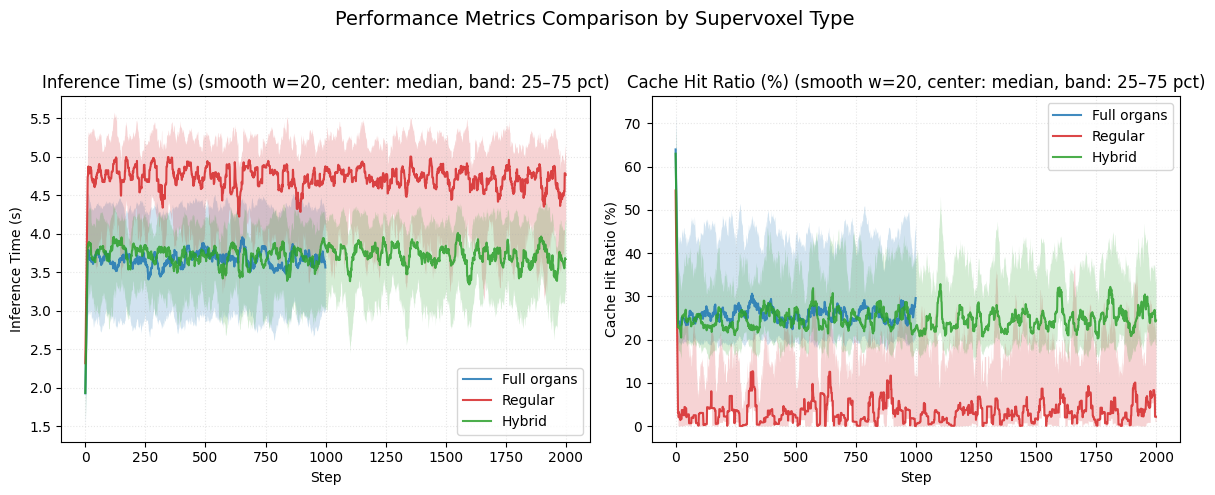

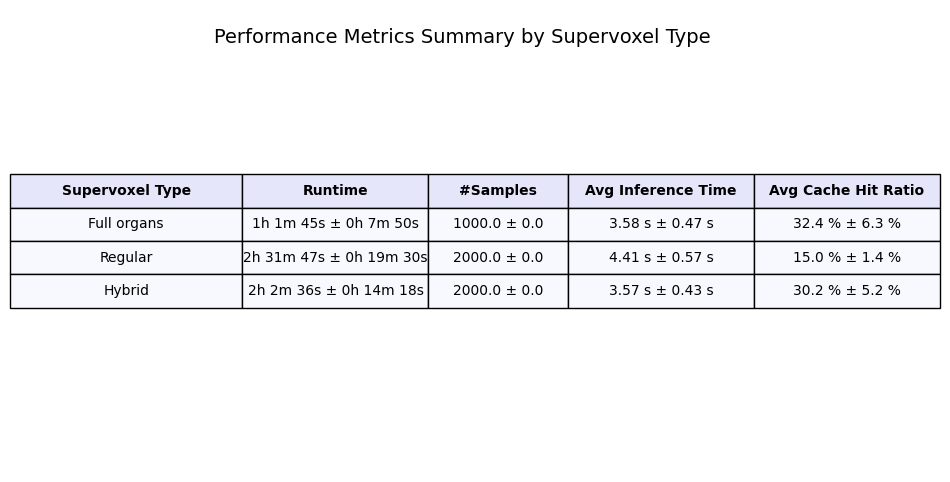

In [15]:
# Create comparison plots using precomputed metrics
dash.plot_comparison(supervoxel_types=["full-organs", "FCC", "FCC-organs"], save=True, band="quantile", quantile=0.25)

## Performance issue gap solved.